In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
pd.set_option("display.max_colwidth", None)

In [6]:
# Load data
df = pd.read_csv('../data/all_queries.csv')

In [7]:
df.head()

,date,time,tweet,tweet_id,hashtags,user_id,username,location,num_followers,geo_enabled,long,lat,relevant,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
0,11/8/21,17:11:01,"Defender Radio Live: Canid Response Teams and Coexistence Lesley Sampson of Coyote Watch Canada joins Defender Radio Podcast host Michael Howie for a live event and recording in Hamilton, Ontario. https://t.co/jLycjr3Xv7",1.460000e+18,[],9.202440e+08,CoyoteWatchCAN,"Ontario, CA",4420,True,NaN,NaN,0.0,0.000,0.912,0.088,0.2023,positive
1,11/8/21,14:25:52,Yaw 💃💃. Good Morning Twitter Family 🤩✨,1.460000e+18,[],1.460000e+18,coyote_kissa1,"Pasadena, CA",57,False,NaN,NaN,0.0,0.000,0.634,0.366,0.6369,positive
2,11/8/21,12:27:50,"At this moment, I have a neighbor that lives 750 away. He keeps his two Labrador retrievers in a 15’ish square pen with a roof outside at night. How do I know this? Because I came hear them barking. Constantly. \n\nApparently they just won a debate with the coyotes. https://t.co/oJV5Swuc3f",1.460000e+18,[],1.330000e+18,DavidCMaybury,"Perris, CA",438,True,NaN,NaN,1.0,0.000,0.930,0.070,0.5719,positive
3,11/8/21,10:51:07,"@AstroBackyard Had the coyotes barking within a few hundred feet of me in Joshua Tree tonight. I shined a light in their direction to let them know I’m aware of them. Oddly, one sounded like a dog.\n\nWhat freaked me out more were the hikers somewhere in the dark. I just heard foot steps!",1.460000e+18,[],6.883438e+07,darrenreely,"Los Angeles, CA",147,True,NaN,NaN,1.0,0.039,0.912,0.049,0.1511,positive
4,11/8/21,8:28:38,"really just saw a coyote cross the street and stare at me as i drove by 😭😭😭 what the, la habra heights",1.460000e+18,[],2.323440e+09,angeIiques,she/her,109,True,NaN,NaN,1.0,0.256,0.744,0.000,-0.8519,negative


In [9]:
df_example = df[df.relevant == 0]['tweet'].head()
df_example

0                                                                                           Defender Radio Live: Canid Response Teams and Coexistence Lesley Sampson of Coyote Watch Canada joins Defender Radio Podcast host Michael Howie for a live event and recording in Hamilton, Ontario.  https://t.co/jLycjr3Xv7
1                                                                                                                                                                                                                                                                                  Yaw 💃💃. Good Morning Twitter Family 🤩✨
6                                                                                                                                                                                                                                                                                           @shenjonsin but the coyotes !
9                                                         

Looks like saving the queries to csv reduced the accuracy of `tweet_id` and `user_id`. This might be a problem in the future and when I join future queries to this main csv. In the time being, I will join on `tweet`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 855 non-null    object 
 1   time                 855 non-null    object 
 2   tweet                855 non-null    object 
 3   tweet_id             855 non-null    float64
 4   hashtags             855 non-null    object 
 5   user_id              855 non-null    float64
 6   username             855 non-null    object 
 7   location             845 non-null    object 
 8   num_followers        855 non-null    int64  
 9   geo_enabled          855 non-null    bool   
 10  long                 5 non-null      float64
 11  lat                  5 non-null      float64
 12  relevant             855 non-null    float64
 13  neg_sent_score       855 non-null    float64
 14  neu_sent_score       855 non-null    float64
 15  pos_sent_score       855 non-null    flo

# Comparing counts of relevant and irrelevant tweets

In [18]:
counts = df.value_counts('relevant')

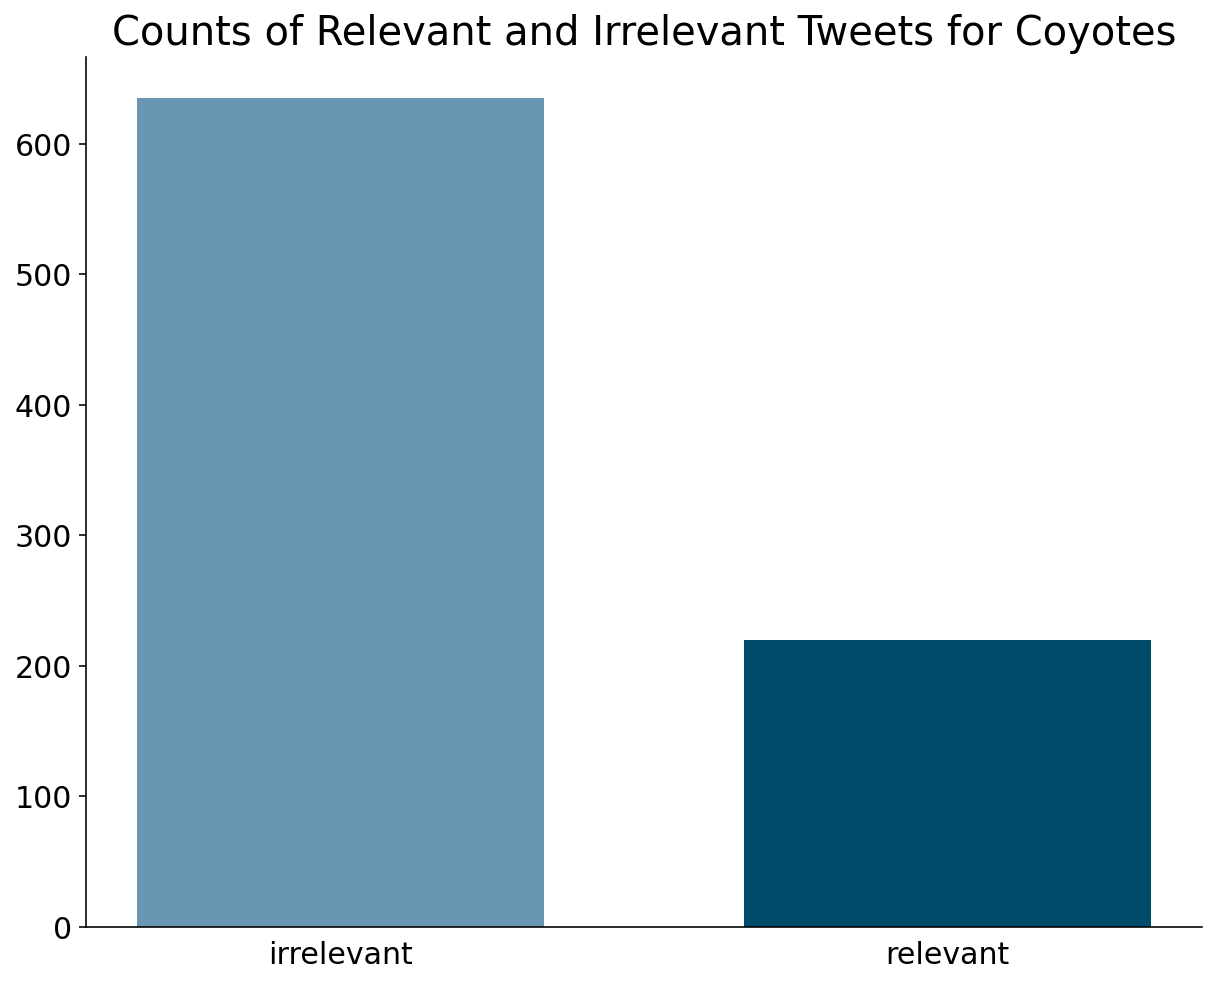

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(['irrelevant', 'relevant'], counts, width=.67, color=['#6996b3', '#004c6d'])
ax.set_title('Counts of Relevant and Irrelevant Tweets for Coyotes', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', bottom=False)
ax.tick_params(axis='both', labelsize=15)

plt.savefig('../images/counts_rel_irrel.png', transparent=True)
plt.show()

# Exploring tweets that are not relevant

In [20]:
df_nr = df[df['relevant'] == 0].copy()

In [21]:
df_nr.shape

(635, 18)

## Look at the tweets

In [22]:
ir_tweets = df_nr['tweet']
ir_tweets[:5]

0     Defender Radio Live: Canid Response Teams and ...
1                Yaw 💃💃. Good Morning Twitter Family 🤩✨
6                         @shenjonsin but the coyotes !
9     Wile E Coyote was a victim. The Road Runner is...
11    @WhatSayU_2020 @DineshDSouza Some children wer...
Name: tweet, dtype: object

### Lets look at the most common words

In [23]:
from utility.text_normalizer import tweet_preprocessor

In [24]:
norm_tweets = [tweet_preprocessor(tweet) for tweet in ir_tweets]
len(norm_tweets)

635

In [25]:
from collections import Counter
from sklearn.feature_extraction import _stop_words

In [26]:
stop_words = _stop_words.ENGLISH_STOP_WORDS

In [27]:
# Get all the words into one list, lowercase them, and remove stopwords
def filter_tweets(tweets: list) -> list:
    all_words = ' '.join(tweets).split(' ')
    all_words = [w.lower() for w in all_words]
    all_words = [w for w in all_words if w not in stop_words]
    all_words = [w for w in all_words if w not in ['coyotes', 'coyote', 'amp']]  # amp is for ampersand
    return all_words

In [28]:
words = filter_tweets(norm_tweets)

In [29]:
word_count = Counter(words)

In [30]:
# Most common 20 words from irrelevant tweets
common_words = word_count.most_common(20)
common_words

[('like', 58),
 ('fur', 36),
 ('just', 32),
 ('los', 30),
 ('time', 27),
 ('dogs', 23),
 ('diagonal', 22),
 ('live', 21),
 ('got', 20),
 ('really', 20),
 ('good', 18),
 ('ducks', 18),
 ('tonight', 18),
 ('game', 18),
 ('foxes', 18),
 ('night', 17),
 ('need', 17),
 ('week', 17),
 ('new', 16),
 ('people', 15)]

### Visualize most common 20 words from irrelevant tweets

In [31]:
irrel_words = []
irrel_counts = []
for current_word, current_count in common_words:
    irrel_words.append(current_word)
    irrel_counts.append(current_count)

irrel_words.reverse()
irrel_counts.reverse()

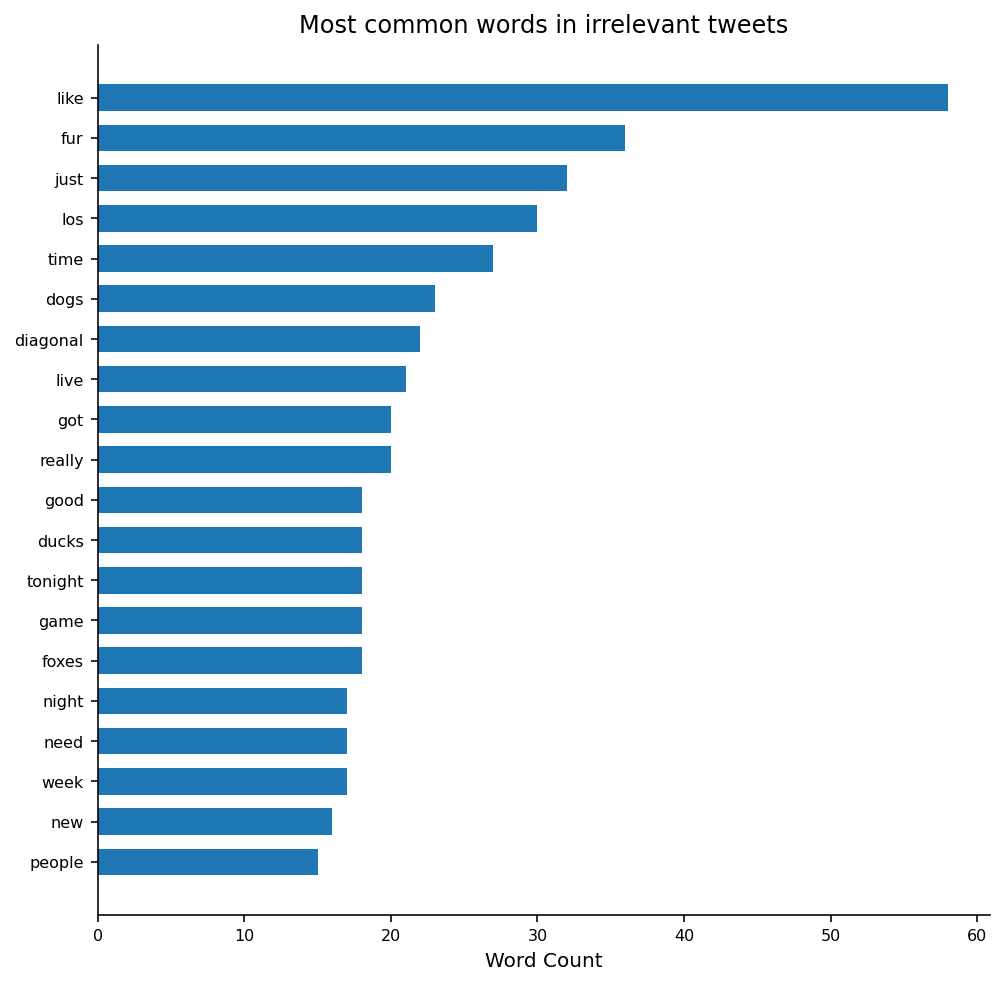

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.barh(irrel_words, irrel_counts, height=.66)
ax.set_title('Most common words in irrelevant tweets')
ax.set_xlabel('Word Count')
ax.tick_params(axis='both', labelsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Based on this plot there are some words we might want to exclude from our twitter api query. These include:
- ducks
- school
- game
- nhl
- win
- arizona
- indian

However, some of these words might be in relevant tweets. Lets take a look at the most common words in relevant tweets.

# Exploring tweets that are relevant

In [33]:
df_rel = df[df['relevant'] == 1].copy()
df_rel.head()

,date,time,tweet,tweet_id,hashtags,user_id,username,location,num_followers,geo_enabled,long,lat,relevant,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
2,11/8/21,12:27:50,"At this moment, I have a neighbor that lives 7...",1.460000e+18,[],1.330000e+18,DavidCMaybury,"Perris, CA",438,True,NaN,NaN,1.0,0.000,0.930,0.070,0.5719,positive
3,11/8/21,10:51:07,@AstroBackyard Had the coyotes barking within ...,1.460000e+18,[],6.883438e+07,darrenreely,"Los Angeles, CA",147,True,NaN,NaN,1.0,0.039,0.912,0.049,0.1511,positive
4,11/8/21,8:28:38,really just saw a coyote cross the street and ...,1.460000e+18,[],2.323440e+09,angeIiques,she/her,109,True,NaN,NaN,1.0,0.256,0.744,0.000,-0.8519,negative
5,11/8/21,7:13:42,my dog just scared tf out of a coyote then cha...,1.460000e+18,[],2.936604e+09,_danimaee,"calabasas, ca",3446,True,NaN,NaN,1.0,0.142,0.782,0.076,-0.4215,negative
7,11/8/21,5:35:38,To make it worse no one else saw the coyote bruh,1.460000e+18,[],7.540000e+17,SPACEAGEPlMP,"Los Angeles, CA",8518,True,NaN,NaN,1.0,0.371,0.629,0.000,-0.6486,negative


In [34]:
df_rel.shape

(220, 18)

In [35]:
rel_tweets = df_rel['tweet']
rel_tweets[:5]

2    At this moment, I have a neighbor that lives 7...
3    @AstroBackyard Had the coyotes barking within ...
4    really just saw a coyote cross the street and ...
5    my dog just scared tf out of a coyote then cha...
7     To make it worse no one else saw the coyote bruh
Name: tweet, dtype: object

In [36]:
norm_rel_tweets = [tweet_preprocessor(tweet) for tweet in rel_tweets]
rel_words = filter_tweets(norm_rel_tweets)
rel_words[:5]

['moment', 'neighbor', 'lives', 'away', 'keeps']

In [37]:
rel_word_count = Counter(rel_words)
common_rel_words = rel_word_count.most_common(20)
common_rel_words

[('just', 42),
 ('dog', 27),
 ('like', 26),
 ('outside', 23),
 ('saw', 22),
 ('seen', 22),
 ('night', 20),
 ('cats', 20),
 ('morning', 20),
 ('pack', 20),
 ('cat', 18),
 ('howling', 17),
 ('neighborhood', 17),
 ('walk', 15),
 ('street', 14),
 ('house', 13),
 ('wildlife', 13),
 ('live', 13),
 ('away', 12),
 ('big', 12)]

In [38]:
rel_words = []
rel_counts = []
for current_word, current_count in common_rel_words:
    rel_words.append(current_word)
    rel_counts.append(current_count)

rel_words.reverse()
rel_counts.reverse()

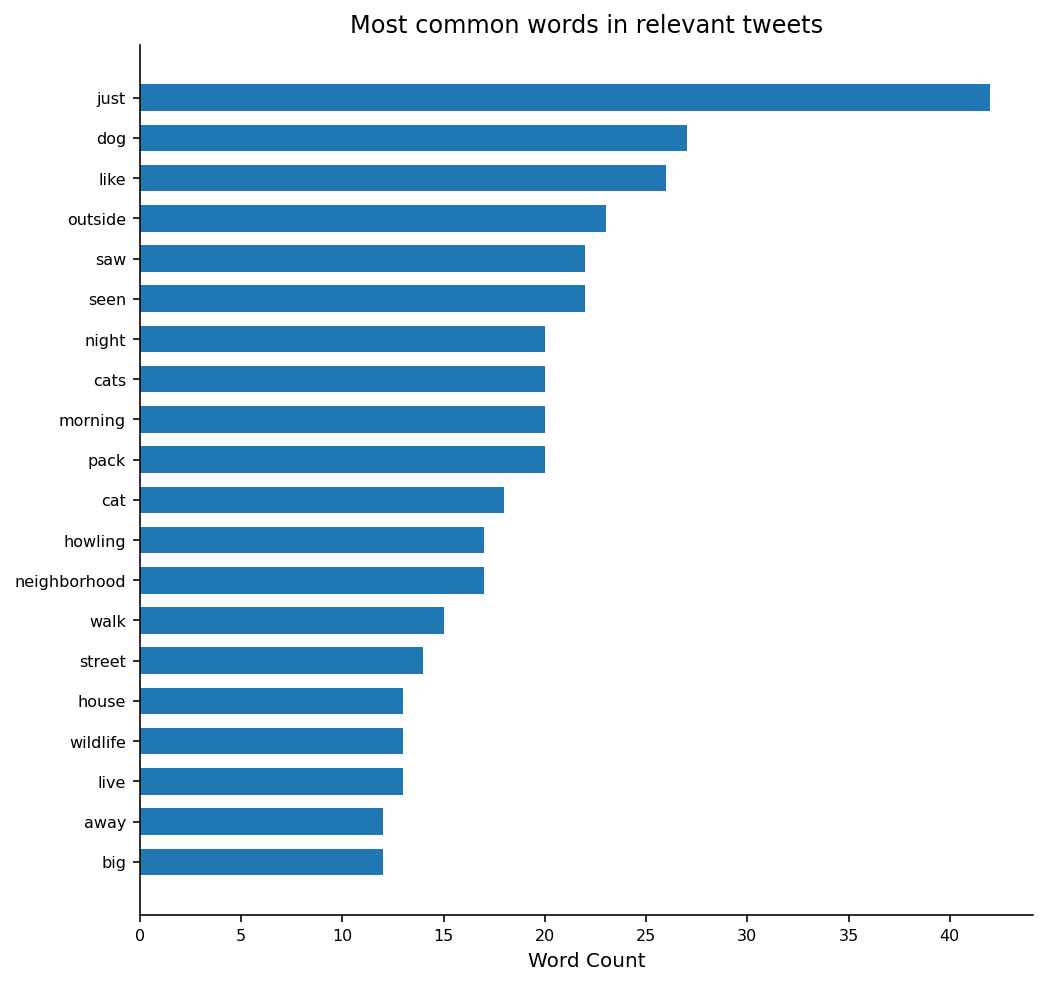

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.barh(rel_words, rel_counts, height=.66)
ax.set_title('Most common words in relevant tweets')
ax.set_xlabel('Word Count')
ax.tick_params(axis='both', labelsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Lets look at words that are in both the most common relevant and irrelevant tweets

In [40]:
rel_words_set = set(rel_words)
irrel_words_set = set(irrel_words)
words_in_both = rel_words_set.intersection(irrel_words_set)
words_in_both

{'just', 'like', 'live', 'night'}

Lets look at the most common words that are only in the irrelevant tweets

In [41]:
only_irrel_words = irrel_words_set - rel_words_set
print(only_irrel_words)

{'really', 'dogs', 'tonight', 'ducks', 'got', 'foxes', 'time', 'new', 'game', 'los', 'week', 'people', 'diagonal', 'fur', 'need', 'good'}


Might be a good idea to remove some of these words. Probably would want to remove the nouns:
- indian
- ducks
- game
- arizona
- school
- nhl
- win (even though its not a noun im assuming its sports related)

### Visualize relevant and irrelevant common words together

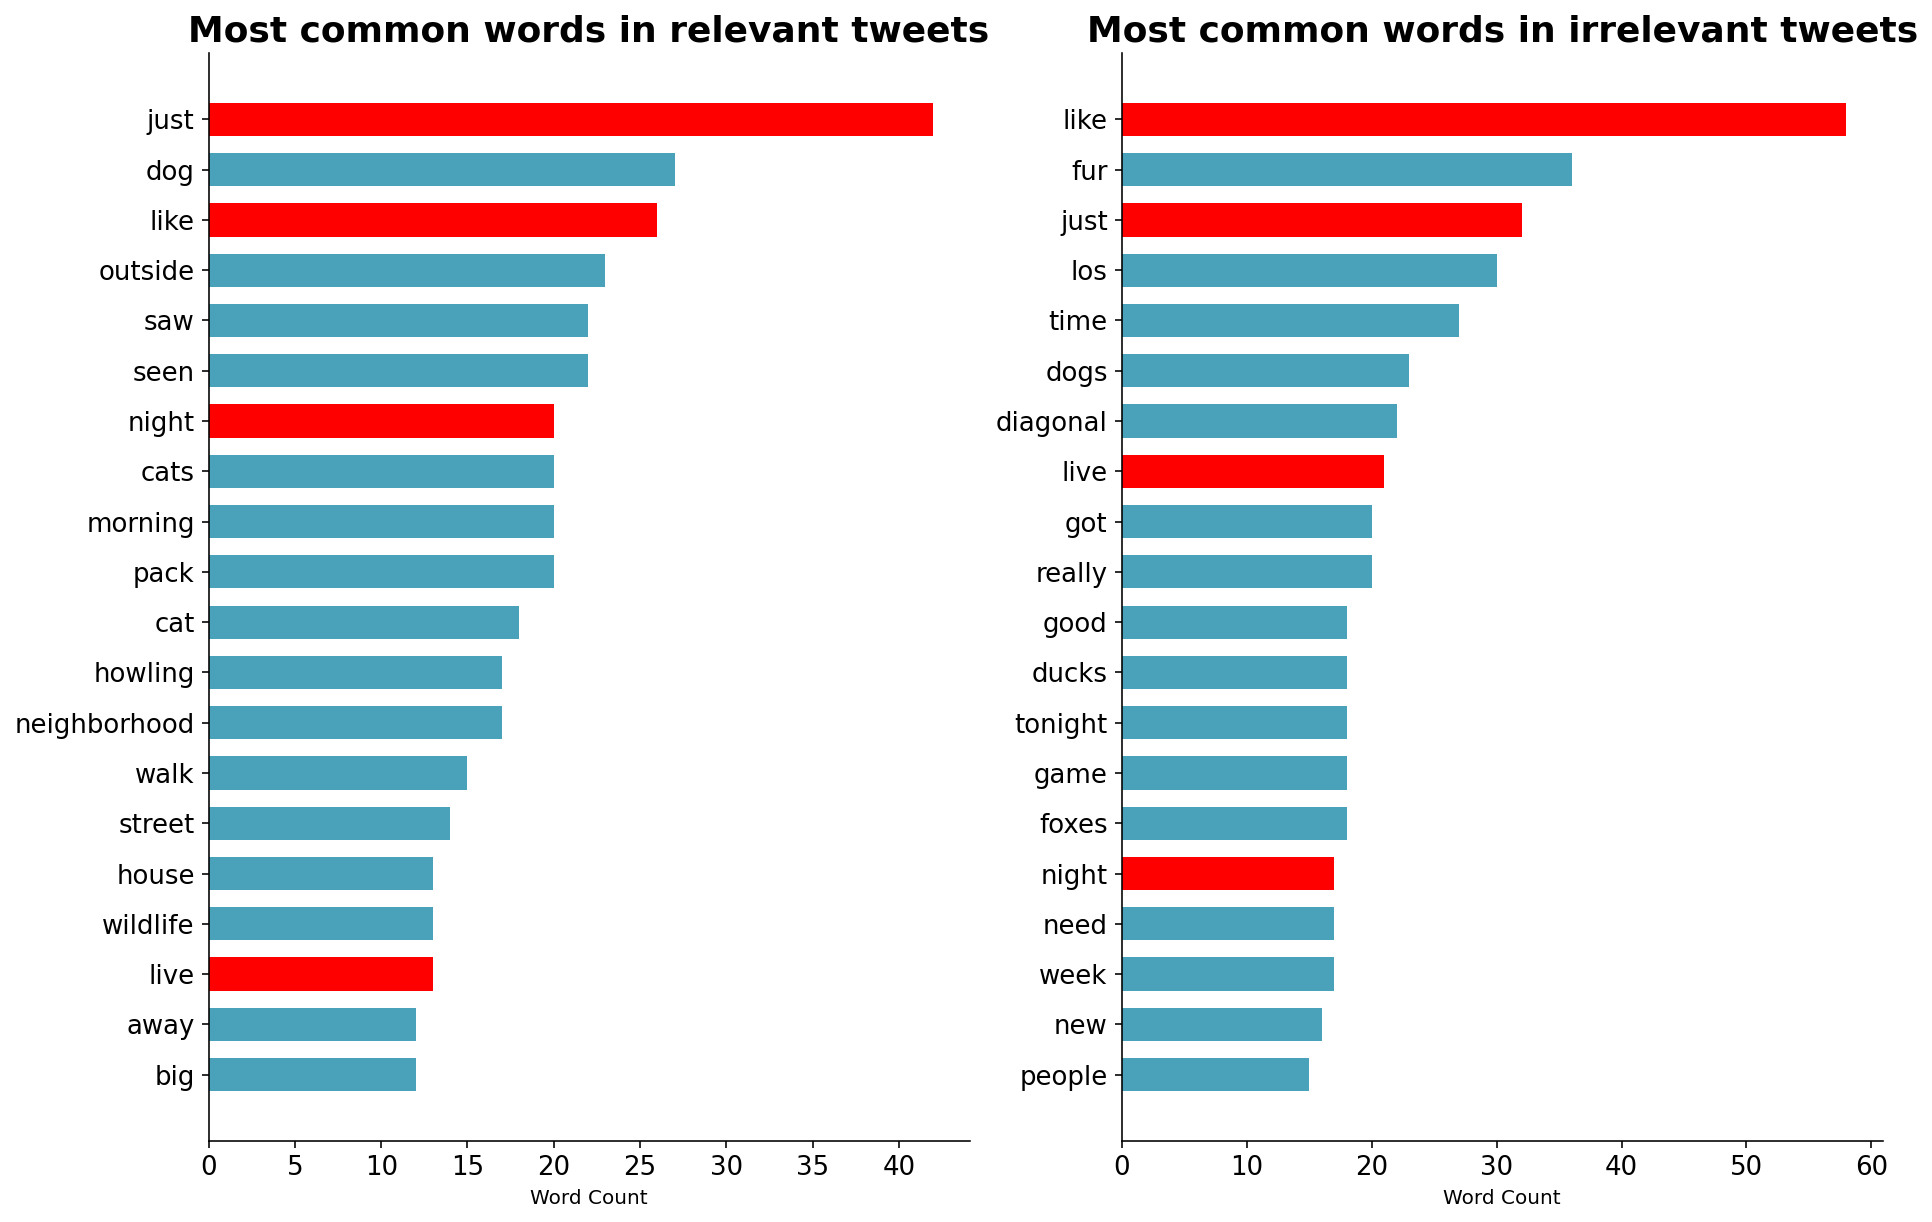

In [53]:
fig, axes = plt.subplots(ncols=2,figsize=(15, 10))
DEFAULT_COLOR = '#49a2b9'
MATCHING_COLOR = 'red'

# Relevant tweets

rel_colors = []
for word in rel_words:
    if word in words_in_both:
        rel_colors.append(MATCHING_COLOR)
    else:
        rel_colors.append(DEFAULT_COLOR)

axes[0].barh(rel_words, rel_counts, height=.66, color=rel_colors)
axes[0].set_title('Most common words in relevant tweets', size=18, weight='bold')
axes[0].set_xlabel('Word Count')
axes[0].tick_params(axis='both', labelsize=13)

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Irrelevant tweets

irrel_colors = []
for word in irrel_words:
    if word in words_in_both:
        irrel_colors.append(MATCHING_COLOR)
    else:
        irrel_colors.append(DEFAULT_COLOR)

axes[1].barh(irrel_words, irrel_counts, height=.66, color=irrel_colors)
axes[1].set_title('Most common words in irrelevant tweets', size=18, weight='bold')
axes[1].set_xlabel('Word Count')
axes[1].tick_params(axis='both', labelsize=13)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

plt.savefig('../images/common_words.png', transparent=True)
plt.show()

# Reclassify tweets

In [48]:
from utility.classify_tweets import *
pd.set_option("display.max_colwidth", None)

In [45]:
classification_values = classify_tweets(df['tweet'], '../bayes_model/best_bayes_pipeline.pkl')

In [69]:
df['rel'] = classification_values

In [ ]:
df[['tweet', 'rel']].sample(5)

In [73]:
df['relevant'] = classification_values

In [76]:
df.tail()

,date,time,tweet,tweet_id,hashtags,user_id,username,location,num_followers,geo_enabled,long,lat,relevant,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class,new_class,rel
735,11/23/21,19:38:47,"Shoutout to when @redsteeze claimed kids separated from their parents at the border were smuggled by coyotes, because he’s a racist dickhole. \n\nThankfully, many have been reunited, and reparations will be paid to the victims of this Trump abomination soon. https://t.co/H0PRlJzaxF",1.460000e+18,[],2.673524e+07,DerenNey,"Oakland, CA",5546,True,NaN,NaN,0.0,0.181,0.761,0.058,-0.7184,negative,0.0,0.0
736,11/23/21,19:36:05,"@stubbylegs @P_Smartypants @NolteNC I was right that the children who were separated were separated from their parents, not coyotes. \n\nYou were wrong. \n\nAnd it has broken you.",1.460000e+18,[],2.673524e+07,DerenNey,"Oakland, CA",5546,True,NaN,NaN,0.0,0.199,0.801,0.000,-0.7351,negative,0.0,0.0
737,11/23/21,19:31:26,"@stubbylegs @P_Smartypants @NolteNC And by the way, I was proven entirely right. They are now paying the parents separated from their children, because they were not coyotes, they were just parents who got separated from their children. I was right — How does that make you feel?",1.460000e+18,[],2.673524e+07,DerenNey,"Oakland, CA",5546,True,NaN,NaN,0.0,0.000,1.000,0.000,0.0000,neutral,0.0,0.0
738,11/23/21,17:12:29,"Two #coyotes, out for a morning hike along the trails in Golden Gate Park. They were on a bit of a mission as they just went straight through, no mingling.\n.\n.\n#urbanwildlife #urbanecology #wildlifephotography https://t.co/2ngSyf9aGX",1.460000e+18,"['coyotes', 'urbanwildlife', 'urbanecology', 'wildlifephotography']",8.980000e+17,EyaSpectre,"San Francisco, CA",680,True,NaN,NaN,1.0,0.058,0.892,0.050,-0.0772,negative,1.0,1.0
739,11/23/21,10:56:10,just heard a mob of coyotes howling,1.460000e+18,[],1.065499e+08,ravioli_jazz,San Francisco,190,False,NaN,NaN,1.0,0.000,1.000,0.000,0.0000,neutral,1.0,1.0


In [77]:
df.drop(columns=['new_class', 'rel'], inplace=True)

In [79]:
df.to_csv('/Users/Isaacbolo/CDFW/CDFW/twitter/coyotes/data/all_queries.csv', index=False, encoding='utf-8-sig')

# Looking at available long and lat data

In [5]:
long = df['long']
lat = df['lat']

In [10]:
long.isnull().sum(), long.notnull().sum()

(850, 5)

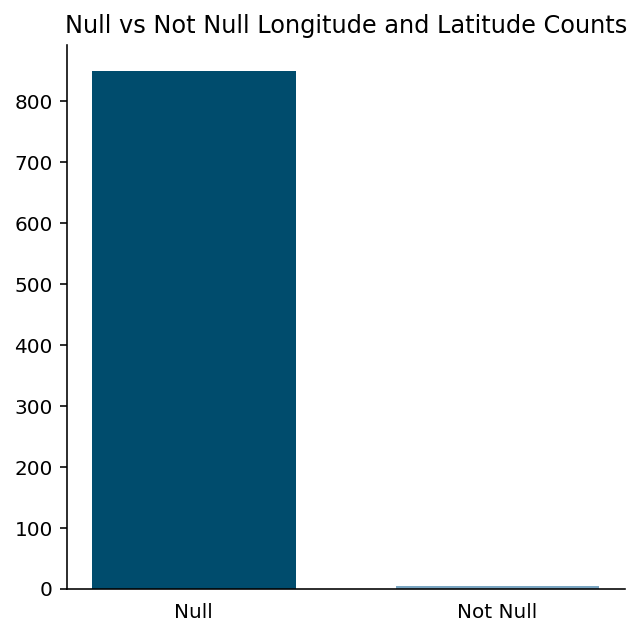

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(['Null', 'Not Null'], [long.isnull().sum(), long.notnull().sum()], color=['#004c6d', '#7aa6c2'], width=.67)
ax.set_title('Null vs Not Null Longitude and Latitude Counts')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', bottom=False)

plt.savefig('../images/count_long_lat.png', transparent=True)
plt.show()